In [1]:
import numpy as np
import pickle as pkl
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.optimize as opti
import scipy, sys, time
import matplotlib.pyplot as plt
from matplotlib import mlab as mlab
from matplotlib.mlab import psd
from tqdm import tqdm
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir

# some settings for standardized figures

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['font.size'] = (24)
plt.rcParams['xtick.labelsize']="medium"
plt.rcParams['text.usetex'] = False

In [2]:
# determine the center position of the attractor at a given time
def osci_pos_func(stroke,time,frequency): 
    osci_pos = stroke/2*np.sin(2*np.pi*time*frequency)
    return osci_pos

def osci_pos_triang_func(stroke,time,frequency,width=0.5):
    osci_pos_triang=stroke/2*signal.sawtooth(2 * np.pi * frequency * time+np.pi/2,width=width)
    return osci_pos_triang

# determine the force for a given point in time using the transformation to position
## sinusoidal movement
def osci_force_func(stroke,time,frequency,pos_vec,force_vec):
    osci_pos = osci_pos_func(stroke,time,frequency)
    return np.interp(osci_pos,pos_vec,force_vec, left=None, right=None, period=None)

## triangle movement
def osci_force_func_tri(stroke,time,frequency,pos_vec,force_vec,width=0.5):
    osci_pos_triang = osci_pos_triang_func(stroke,time,frequency,width=width)
    return np.interp(osci_pos_triang,pos_vec,force_vec, left=None, right=None, period=None)

# little helper to get the bin of a histogram at which a certain invertall in % is reached
def fraction_of_histo(input_histo,bins=500,intervall=0.68):
    hist_list =[]
    h1 = plt.hist(input_histo,bins,density=True,cumulative=True)
    [hist_list.append(h1[1][bins]) for bins in np.arange(0,len(h1[1])-1,1) if h1[0][bins]>intervall]
    plt.xlabel("ASD [Hz]")
    plt.ylabel("CDF")
    plt.axvline(np.min(hist_list),color="red",linestyle="dashed")
    plt.axhline(intervall,color="red",linestyle="dashed")
    #plt.show()
    return np.min(hist_list)
          
# normalization for used ASD
def fft_norm(N, fsamp):
    return np.sqrt(2 / (N * fsamp))

### CHECK WHITE NOISE
def generate_white_noise(length,fs,noise_floor):
    noise_randomized = noise_floor * np.random.randn(length)
    fft = np.abs(np.fft.rfft(noise_randomized))
    freq3 = np.fft.rfftfreq(length, d=1./fs)
    ps = fft*fft.conj().real*fft_norm(length,fs)**2
    return ps,freq3


def generate_white_noise2(length,fs,noise_floor):
    noise_randomized = noise_floor * np.random.randn(length)
    psd_noise,freq_n = psd(noise_randomized,NFFT=length,Fs=fs, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    norm=0.5*fs
    return psd_noise*norm,freq_n

# get noise response for a number of harmonics
def noise_response(no_harmonics,frequency,noise_floor):
    noise_response = 0
    noise_value = generate_white_noise(5000,5000,noise_floor)[0]
    for j in no_harmonics:
        noise_response += noise_value[j*frequency]
        
    return noise_response

def noise_response_per_harmonics(no_harmonics,frequency,noise_floor):
    noise_response = []
    noise_value = generate_white_noise(5000,5000,noise_floor)[0]
    for j in no_harmonics:
        noise_response.append(noise_value[j*frequency])
    return noise_response


# define a function to obtain the response given a number of harmonics (normalization)
def function_response(alpha,int_time,fs,pos_vec,force_vec,stroke,frequency,no_harmonics,plot,manual):
    force_vec = force_vec * alpha # scale the force vector by alpha
    time = np.arange(0,int_time,1/sampling_frequency) # make a time array, default 1s
    length = len(osci_force_func(stroke,time,frequency,pos_vec,force_vec)) # length of the array
    
    # calculate the psd "manually"
    fft = np.abs(np.fft.rfft(osci_force_func(stroke,time,frequency,pos_vec,force_vec))) 
    freq = np.fft.rfftfreq(length, d=1./fs)
    psd_dat1 = fft*fft.conj().real*fft_norm(len(noise_randomized),fs)**2
    
    # let mlab do the job
    psd_dat2,freq2 = psd(osci_force_func(stroke,time,frequency,pos_vec,force_vec), 
                         NFFT=length, 
                         Fs=fs, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    response =0
    if(plot==True):
        plt.plot(freq2,np.sqrt(psd_dat2))
        plt.yscale("log")
        plt.xlim(0,340)
    for i in no_harmonics:
        if(manual==True):
            response+=np.sqrt(psd_dat1[i*frequency])
        if(manual==False):    
            response+=np.sqrt(psd_dat2[i*frequency])
        #print(response,i*frequency)
    return response

In [3]:
def function_response_2(alpha,int_time,sampling_frequency,pos_vec,force_vec,stroke,frequency,no_harmonics,bkg=False,plot=False):
    force_vec = force_vec * alpha
    sampling_frequency = 5000
    time = np.arange(0,int_time,1/sampling_frequency)
    fft_0 = np.fft.rfft(osci_force_func(stroke,time,frequency,pos_vec,force_vec))
    fft_1 = np.abs(fft_0)
    freq2 = np.fft.rfftfreq(5000, d=1./5000)
    psd_dat2 = fft_1*fft_1.conj().real*fft_norm(len(osci_force_func(stroke,time,frequency,pos_vec,force_vec)),5000)**2
    
    response =0
    response_list=[]
    phase_list=[]
    if(bkg==True):frequency=frequency+2
    for i in np.arange(1,no_harmonics+1,1):
        response+=np.sqrt(psd_dat2[i*frequency])
        freq_selec = np.arange(frequency,frequency*(no_harmonics+1),frequency)
        response_list.append(np.sqrt(psd_dat2[i*frequency]))
        phase_list.append(np.angle(fft_0[i*frequency]))
    if(plot==True):            
        plt.plot(freq_selec,response_list)
        plt.yscale("log")
        plt.xlim(0,frequency*no_harmonics+5)
        plt.show()
        plt.plot(freq_selec,np.divide(phase_list,np.pi),marker="*")
        plt.xlim(0,frequency*no_harmonics+5)
        #print(response,i*frequency)
    return (response,freq_selec,response_list,phase_list)

In [4]:
def measurement_response(alpha,int_time,fs,pos_vec,force_vec,stroke,frequency,noise_floor,no_harmonics,plot,manual):
    force_vec = force_vec * alpha # scale the force vector by alpha
    time = np.arange(0,int_time,1/sampling_frequency) # make a time array, default 1s
    length = len(osci_force_func(stroke,time,frequency,pos_vec,force_vec)) # length of the array
    #noise_floor = 1.85*np.pi*1e-17
    signal = osci_force_func(stroke,time,frequency,pos_x,force_vec)
    noise = noise_floor  * np.random.randn(length)
    background = 0 # implement later
    measurement = noise + signal + background
    
    
    # calculate the psd "manually"
    fft = np.abs(np.fft.rfft(measurement)) 
    freq = np.fft.rfftfreq(length, d=1./fs)
    psd_dat1 = fft*fft.conj().real*fft_norm(length,fs)**2
    
    # let mlab do the job
    psd_dat2,freq2 = psd(measurement, 
                         NFFT=length, 
                         Fs=fs, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    response =0
    if(plot==True):
        plt.plot(freq2,np.sqrt(psd_dat2))
        plt.yscale("log")
        plt.xlim(0,np.max(no_harmonics)*frequency)
        plt.show()
    for i in no_harmonics:
        if(manual==True):
            response+=psd_dat1[i*frequency]
        if(manual==False):    
            response+=psd_dat2[i*frequency]
        #print(response,i*frequency)
    return response

In [13]:
def measurement_response_harmonics(alpha,int_time,fs,pos_vec,force_vec,stroke,frequency,noise_floor,no_harmonics,plot,manual):
    force_vec = force_vec * alpha # scale the force vector by alpha
    time = np.arange(0,1,1/sampling_frequency) # make a time array, default 1s
    length = len(osci_force_func(stroke,time,frequency,pos_vec,force_vec)) # length of the array
    #noise_floor = 1.85*np.pi*1e-17
    signal = osci_force_func(stroke,time,frequency,pos_x,force_vec)
    noise = noise_floor/np.sqrt(int_time)  * np.random.randn(length)
    background = 0 # implement later
    measurement = noise + signal + background
    
    
    # calculate the psd "manually"
    fft = np.abs(np.fft.rfft(measurement)) 
    freq = np.fft.rfftfreq(length, d=1./fs)
    psd_dat1 = fft*fft.conj().real*fft_norm(length,fs)**2
    
    # let mlab do the job
    psd_dat2,freq2 = psd(measurement, 
                         NFFT=length, 
                         Fs=fs, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    response = []
    if(plot==True):
        plt.plot(freq2,np.sqrt(psd_dat2))
        plt.yscale("log")
        plt.xlim(0,np.max(no_harmonics)*frequency)
        plt.show()
    for i in no_harmonics:
        if(manual==True):
            response.append(psd_dat1[i*frequency])
        if(manual==False):    
            response.append(psd_dat2[i*frequency])
        #print(response,i*frequency)
    return response

In [6]:
## load the data dictionary file (its usually of the form results_dic[rbead][sep][height][yuklambda])

res_dict_side_by_side = pkl.load( open('/home/analysis_user/Results/Sensitivity/rbead_2.4e-06_sep_7.5e-06_height_0.p', 'rb'))


In [7]:
## initate a few values in order to do diagnostics
int_time = 1 # keep that 1 for now
alpha = 1 # alpha to scale the yukawa force
sampling_frequency = 5000 # should be 5000 
time = np.arange(0,int_time,1/sampling_frequency) # make a time array
separation = 7.5e-6 # separation is set by the file you load TODO automatize


In [8]:
lambda_par= 1e-5 # pick a lambda parameter
force_x = res_dict_side_by_side[2.4e-6][separation][0][lambda_par][0] # force in direction of the sphere
force_x_yuk = alpha*res_dict_side_by_side[2.4e-6][separation][0][lambda_par][3] # force by the yukawa potential
pos_x = res_dict_side_by_side["posvec"] # get the position of the bead from the dictionary

In [9]:
### calculate the best alpha


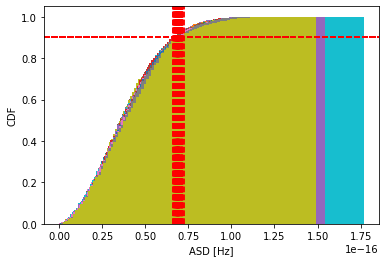

In [10]:
### get noise limit list
frequency = 13
noise_floor = 230*1e-17
no_harmonics = np.arange(1,100,1)
noise_resp_list=[]
limit_list=[]
noise_resp_per_harmonic =0
for k in np.arange(0,1000,1):    
    noise_resp_list.append(noise_response_per_harmonics(no_harmonics,frequency,noise_floor))
noise_resp_per_harmonic = np.stack(np.sqrt(noise_resp_list), axis=1)
for j in no_harmonics-1:
    limit_list.append(fraction_of_histo(noise_resp_per_harmonic[j],bins=100,intervall=0.9))
cumsum_signal =[]
cumsum_noise = np.cumsum(limit_list)    

In [23]:
no_harmonics = [2]
alpha_list=[]
signal_list=[]
signal_list2=[]

for alpha in tqdm(np.geomspace(1e05,1e14,90)):
        response_list=[]
        alpha_list.append(alpha)
        for k in np.arange(0,10000,1):
            response_list.append(measurement_response_harmonics(alpha=alpha,int_time=1,fs=5000,pos_vec=pos_x,force_vec=force_x_yuk,stroke=500e-6,frequency=frequency,noise_floor=noise_floor,no_harmonics=no_harmonics,plot=False,manual=False))
        signal_resp_per_harmonic = np.stack(np.sqrt(response_list), axis=1)
        for i in np.arange(0,len(no_harmonics),1):
            signal_list.append(np.mean(signal_resp_per_harmonic[i]))
signal_list2 = np.reshape(signal_list,(90,len(no_harmonics)))



 43%|████▎     | 39/90 [05:01<06:30,  7.65s/it]

KeyboardInterrupt: 

In [ ]:
for j,signal in enumerate(signal_list):
    if(signal>limit_list[2]):
        print(signal,j)
        print(alpha_list[j])
        break

(1e-17, 1e-16)

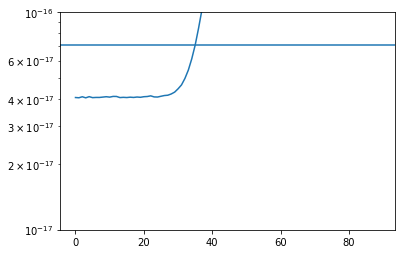

In [13]:
plt.plot(signal_list)
plt.axhline(limit_list[2])
plt.yscale("log")
plt.ylim(1e-17,1e-16)

In [14]:
len(limit_list)

99

In [25]:
no_harmonics = [4]
alpha_list=[]
lambda_list=[]
lambda_yuk_vals= np.logspace(-6.3, -3, 100)
lambda_yuk_vals = lambda_yuk_vals[::-1]


for lambda_yuk in tqdm(lambda_yuk_vals):
    signal_list=[]
    alpha_list=[]
    force_x_yuk = res_dict_side_by_side[2.4e-6][separation][0][lambda_yuk][3] # force by the yukawa potential
    for alpha in np.geomspace(1e05,1e14,90):
        response_list=[]
        alpha_list.append(alpha)
        for k in np.arange(0,500,1):
            response_list.append(measurement_response_harmonics(alpha=alpha,int_time=1,fs=5000,pos_vec=pos_x,force_vec=force_x_yuk,stroke=400e-6,frequency=frequency,noise_floor=noise_floor,no_harmonics=no_harmonics,plot=False,manual=False))
        signal_resp_per_harmonic = np.stack(np.sqrt(response_list), axis=1)
        for i in np.arange(0,len(no_harmonics),1):
            signal_list.append(np.mean(signal_resp_per_harmonic[i]))
    for j,signal in enumerate(signal_list):
        #print(signal)
        if(signal>limit_list[2]):
            lambda_list.append(alpha_list[j])
            #print(signal,alpha_list[j])
            break
    
#signal_list2 = np.reshape(signal_list,(90,len(no_harmonics)))


100%|██████████| 100/100 [54:36<00:00, 32.77s/it]


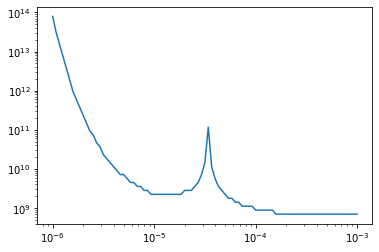

In [27]:
plt.plot(lambda_yuk_vals[:len(lambda_list)],lambda_list)
plt.yscale("log")
plt.xscale("log")


In [28]:
no_harmonics = [4]
alpha_list=[]
lambda_list=[]
lambda_yuk_vals= np.logspace(-6.3, -3, 100)
lambda_yuk_vals = lambda_yuk_vals[::-1]


for lambda_yuk in tqdm(lambda_yuk_vals):
    signal_list=[]
    alpha_list=[]
    force_x_yuk = res_dict_side_by_side[2.4e-6][separation][0][lambda_yuk][3] # force by the yukawa potential
    for alpha in np.geomspace(1e05,1e14,90):
        response_list=[]
        alpha_list.append(alpha)
        for k in np.arange(0,50,1):
            response_list.append(measurement_response_harmonics(alpha=alpha,int_time=1,fs=5000,pos_vec=pos_x,force_vec=force_x_yuk,stroke=400e-6,frequency=frequency,noise_floor=noise_floor,no_harmonics=no_harmonics,plot=False,manual=False))
        signal_resp_per_harmonic = np.stack(np.sqrt(response_list), axis=1)
        for i in np.arange(0,len(no_harmonics),1):
            signal_list.append(np.mean(signal_resp_per_harmonic[i]))
    for j,signal in enumerate(signal_list):
        #print(signal)
        if(signal>limit_list[2]):
            lambda_list.append(alpha_list[j])
            #print(signal,alpha_list[j])
            break
    
#signal_list2 = np.reshape(signal_list,(90,len(no_harmonics)))


100%|██████████| 100/100 [05:28<00:00,  3.29s/it]


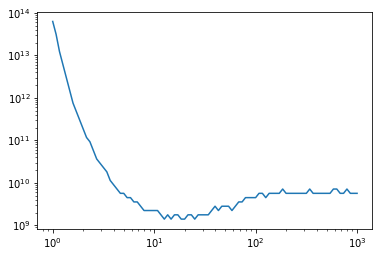

In [31]:
plt.plot(lambda_yuk_vals[:len(lambda_list)]/1e-6,lambda_list)
plt.yscale("log")
plt.xscale("log")


In [32]:
no_harmonics = [3]
alpha_list=[]
lambda_list=[]
lambda_yuk_vals= np.logspace(-6.3, -3, 100)
lambda_yuk_vals = lambda_yuk_vals[::-1]


for lambda_yuk in tqdm(lambda_yuk_vals):
    signal_list=[]
    alpha_list=[]
    force_x_yuk = res_dict_side_by_side[2.4e-6][separation][0][lambda_yuk][3] # force by the yukawa potential
    for alpha in np.geomspace(1e05,1e14,90):
        response_list=[]
        alpha_list.append(alpha)
        for k in np.arange(0,50,1):
            response_list.append(measurement_response_harmonics(alpha=alpha,int_time=1,fs=5000,pos_vec=pos_x,force_vec=force_x_yuk,stroke=400e-6,frequency=frequency,noise_floor=noise_floor,no_harmonics=no_harmonics,plot=False,manual=False))
        signal_resp_per_harmonic = np.stack(np.sqrt(response_list), axis=1)
        for i in np.arange(0,len(no_harmonics),1):
            signal_list.append(np.mean(signal_resp_per_harmonic[i]))
    for j,signal in enumerate(signal_list):
        #print(signal)
        if(signal>limit_list[2]):
            lambda_list.append(alpha_list[j])
            #print(signal,alpha_list[j])
            break
    
#signal_list2 = np.reshape(signal_list,(90,len(no_harmonics)))


100%|██████████| 100/100 [05:28<00:00,  3.29s/it]


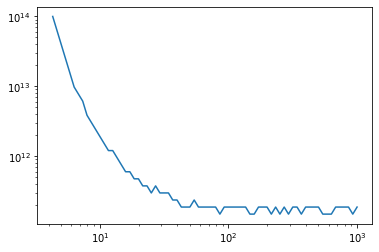

In [33]:
plt.plot(lambda_yuk_vals[:len(lambda_list)]/1e-6,lambda_list)
plt.yscale("log")
plt.xscale("log")


In [20]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = 24


def alpha_response(alpha):
    response_list=[]
    for k in np.arange(0,500,1):
        response_list.append(measurement_response_harmonics(alpha=alpha,int_time=1e5,fs=5000,pos_vec=pos_x,force_vec=force_x_yuk,stroke=300e-6,frequency=frequency,noise_floor=noise_floor,no_harmonics=no_harmonics,plot=False,manual=False))
    signal_resp_per_harmonic = np.stack(np.sqrt(response_list), axis=1)
    return np.mean(signal_resp_per_harmonic)

In [21]:
no_harmonics = [6]
alpha_list=[]
lambda_list=[]
lambda_yuk_vals= np.logspace(-6.3, -3, 100)
lambda_yuk_vals = lambda_yuk_vals[::-1]


for lambda_yuk in tqdm(lambda_yuk_vals[:]):
    #print(lambda_yuk)
    signal_list=[]
    alpha_list=np.geomspace(1e3,1e13,300)
    force_x_yuk = res_dict_side_by_side[2.4e-6][separation][0][lambda_yuk][3] # force by the yukawa potential
    alpha_result = Parallel(n_jobs=num_cores)(delayed(alpha_response)(alpha) for alpha in alpha_list)
    lambda_list.append(alpha_list[next(x[0] for x in enumerate(alpha_result) if x[1] > (limit_list[2])/np.sqrt(1e5))])
    

    
#signal_list2 = np.reshape(signal_list,(90,len(no_harmonics)))





  0%|          | 0/100 [00:00<?, ?it/s]


  1%|          | 1/100 [00:06<11:05,  6.72s/it]


  2%|▏         | 2/100 [00:12<10:44,  6.58s/it]


  3%|▎         | 3/100 [00:19<10:39,  6.59s/it]


  4%|▍         | 4/100 [00:25<10:22,  6.49s/it]


  5%|▌         | 5/100 [00:32<10:13,  6.46s/it]


  6%|▌         | 6/100 [00:38<10:03,  6.42s/it]


  7%|▋         | 7/100 [00:44<09:49,  6.34s/it]


  8%|▊         | 8/100 [00:50<09:39,  6.30s/it]


  9%|▉         | 9/100 [00:57<09:32,  6.29s/it]


 10%|█         | 10/100 [01:03<09:18,  6.21s/it]


 11%|█         | 11/100 [01:09<09:18,  6.28s/it]


 12%|█▏        | 12/100 [01:16<09:23,  6.40s/it]


 13%|█▎        | 13/100 [01:22<09:16,  6.40s/it]


 14%|█▍        | 14/100 [01:28<09:06,  6.36s/it]


 15%|█▌        | 15/100 [01:35<08:58,  6.33s/it]


 16%|█▌        | 16/100 [01:41<08:55,  6.37s/it]


 17%|█▋        | 17/100 [01:48<08:49,  6.38s/it]


 18%|█▊        | 18/100 [01:54<08:40,  6.35s/it]


 19%|█▉        | 19/100 [02:00<08:28,  6.28s/i

StopIteration: 

In [22]:
lambda_list

[2387406.771860647,
 2387406.771860647,
 2210454.6299710195,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2210454.6299710195,
 2578524.3528842763,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2210454.6299710195,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2578524.3528842763,
 2578524.3528842763,
 2387406.771860647,
 2387406.771860647,
 2387406.771860647,
 2578524.3528842763,
 2578524.3528842763,
 2578524.3528842763,
 2578524.35

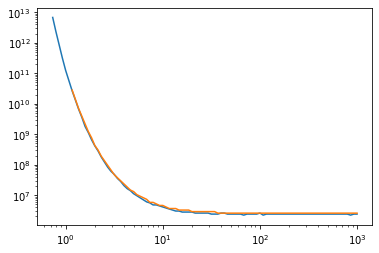

In [36]:
lambdas_real = np.loadtxt("Results/alpha_7.50e-06_sep_3.00e-04_stroke_2500_k_6_harmonics_20190902.txt")
alphas_real = np.loadtxt("Results/lambda_7.50e-06_sep_3.00e-04_stroke_2.50e+03_k_6_harmonics_20190902.txt")

plt.plot(lambda_yuk_vals[:len(lambda_list)]/1e-6,lambda_list)
plt.plot(lambdas_real/1e-6,alphas_real/np.sqrt(1e5))
plt.yscale("log")
plt.xscale("log")


In [77]:
x = np.linspace(1,1000,10000)
x_val = lambda_yuk_vals[:len(lambda_list)]/1e-6

In [79]:
test = np.interp(x,x_val,lambda_list, left=None, right=None, period=None)


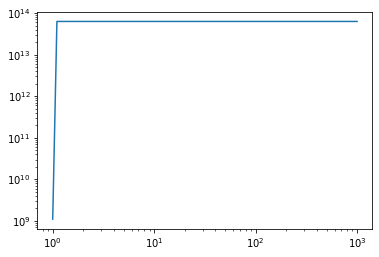

In [80]:
plt.plot(x,test)
plt.yscale("log")
plt.xscale("log")

In [66]:
x

array([   1.        ,    1.00069108,    1.00138264, ...,  998.61926487,
        999.30939397, 1000.        ])

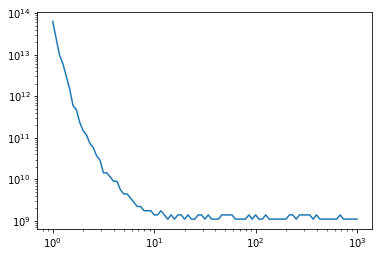

In [71]:
plt.plot(lambda_yuk_vals[:len(lambda_list)]/1e-6,lambda_list)
plt.yscale("log")
plt.xscale("log")


In [100]:
x_val

array([1.00000000e+03, 9.26118728e+02, 8.57695899e+02, 7.94328235e+02,
       7.35642254e+02, 6.81292069e+02, 6.30957344e+02, 5.84341413e+02,
       5.41169527e+02, 5.01187234e+02, 4.64158883e+02, 4.29866235e+02,
       3.98107171e+02, 3.68694506e+02, 3.41454887e+02, 3.16227766e+02,
       2.92864456e+02, 2.71227258e+02, 2.51188643e+02, 2.32630507e+02,
       2.15443469e+02, 1.99526231e+02, 1.84784980e+02, 1.71132830e+02,
       1.58489319e+02, 1.46779927e+02, 1.35935639e+02, 1.25892541e+02,
       1.16591440e+02, 1.07977516e+02, 1.00000000e+02, 9.26118728e+01,
       8.57695899e+01, 7.94328235e+01, 7.35642254e+01, 6.81292069e+01,
       6.30957344e+01, 5.84341413e+01, 5.41169527e+01, 5.01187234e+01,
       4.64158883e+01, 4.29866235e+01, 3.98107171e+01, 3.68694506e+01,
       3.41454887e+01, 3.16227766e+01, 2.92864456e+01, 2.71227258e+01,
       2.51188643e+01, 2.32630507e+01, 2.15443469e+01, 1.99526231e+01,
       1.84784980e+01, 1.71132830e+01, 1.58489319e+01, 1.46779927e+01,
      

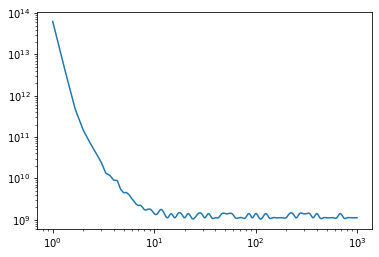

In [117]:
from scipy.interpolate import make_interp_spline, BSpline

xnew = np.linspace(x_val.min(),x_val.max(),3000) #300 represents number of points to make between T.min and T.max

spl = make_interp_spline(sorted(x_val), lambda_list, k=3) #BSpline object
power_smooth = spl(xnew)

plt.plot(xnew,power_smooth)
plt.yscale("log")
plt.xscale("log")
plt.show()

In [ ]:
plt.plot(lambda_yuk_vals[:len(lambda_list)]/1e-6,lambda_list)
plt.yscale("log")
plt.xscale("log")